___

# [ Machine Learning in Geosciences ] 
Department of Applied Geoinformatics and Carthography, Charles University

Lukas Brodsky lukas.brodsky@natur.cuni.cz


## Fundamental Algorithms: SVM 


**Purpose**: explore SVM and plot decisionboundary. 

Recall, SVMs are classifiers that attemt to maximise the separation between classes, no matter what the distribution of the data. This means that they can sometimes fit noise more than they fit the data.

But because they are aiming to separate classes, they do a really good job at optimising for accuracy.

**Tasks**: 

1/ vary the `C` and `gamma` parameters manually to see the effects

2/ try to change the `kernel`


# Setup

In [8]:
# Common imports for reading, visualizing
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# utilities
from IPython.display import display
from sklearn import datasets
from sklearn import preprocessing

# model
from sklearn.svm import SVC

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

colors = "bry"

# Project dir
PROJECT_DIR = "./"
if os.path.isdir(PROJECT_DIR):
    print('Ok continue.')
else:
    print('Nok, set correct path to your project directory!')

Ok continue.


## Get data


In [9]:
iris = datasets.load_iris()
feat = iris.feature_names
X = iris.data[:, :2]  # we only take the first two features. We could
                      # avoid this ugly slicing by using a two-dim dataset
y = iris.target
y[y != 0] = 1 # Only use two targets for now


In [10]:
# standardize
X = preprocessing.StandardScaler().fit_transform(X)

## Use linear SVM model 

In [12]:
# Create a linear SVM
# high C -> no tolerance of misclassification
svm_clf = SVC(kernel='linear', C=10000.0).fit(X, y)

In [13]:
# a function to plot the decision boundary and separation found by a liner SVM

def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, "k-", linewidth=2, label="SVM")
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)

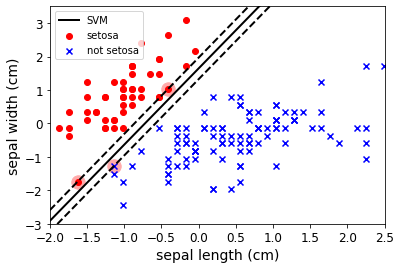

In [14]:
# plotting it! 
plot_svc_decision_boundary(svm_clf, -2, 2)
plt.scatter(X[y == 0, 0], X[y == 0, 1],
            color='red', marker='o', label='setosa')
plt.scatter(X[y != 0, 0], X[y != 0, 1],
            color='blue', marker='x', label='not setosa')
plt.axis([-2, 2.5, -3, 3.5])
plt.xlabel(feat[0])
plt.ylabel(feat[1])
plt.legend(loc='upper left')
plt.show()

Note how the **SVM has maximised the separation** between the classes and also allowed some datapoints to enter within the boundary. 
The SVM parameter **C** is a penalty parameter that specifies whether it should force the separation of the classes (C=inf) or allow some points to be misclassified to obtain a better fit (C=small).

Now, allow some level of misclassification to get a better decision boundary!

## Update the SVM to soft margin 

In [17]:
# update the model by modifying the C parametr to low value 
# ~low C -> we tolerate misclassification 
svm_clf = SVC(kernel='linear', C=0.1).fit(X, y)

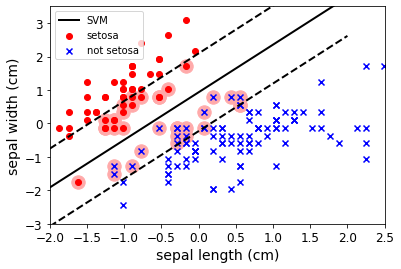

In [18]:
# plot the model 
plot_svc_decision_boundary(svm_clf, -2, 2)
plt.scatter(X[y == 0, 0], X[y == 0, 1],
            color='red', marker='o', label='setosa')
plt.scatter(X[y != 0, 0], X[y != 0, 1],
            color='blue', marker='x', label='not setosa')
plt.axis([-2, 2.5, -3, 3.5])
plt.xlabel(feat[0])
plt.ylabel(feat[1])
plt.legend(loc='upper left')
plt.show()

## Non-linear SVM (kernel trick) 

Recall that it is possible to transform the input data without compromising the integrity of the data. 

The transformation simply needs to be invertible. The **kernel trick** is a method to transform the data by a complex (invertible) function to allow more complex decision boundaries.

Let's example the RBF (**radial basis function**) as our kernel. RBF is basically a multi-dimensional gaussian. We **specify the width of this kernel** with the `gamma` parameter. 
Smaller values of gamma will produce more complex boundaries (less smoothing).

In [20]:
# update the model with specifying the kernel 
# from sklearn.svm import SVC

# one issue with SVMs is that they are quite complex to tune, because of all the different parameters.
rbf_svc = SVC(kernel='rbf', gamma=0.7, C=1000.0).fit(X, y)

In [21]:
# plotting function to plot the decision regions of complex decision boundaries

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02, labels=['setosa', 'not setosa'], X_plot=None):

    if X_plot is None:
        X_plot = X

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                         np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot all samples
    X_test, y_test = X[test_idx, :], y[test_idx]
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=cmap(idx),
                    marker=markers[idx], label=labels[cl])

    # highlight test samples
    if test_idx:
        X_test, y_test = X[test_idx, :], y[test_idx]
        plt.scatter(X_test[:, 0], X_test[:, 1], c='',
                alpha=1.0, linewidth=1, marker='o',
                s=55, label='test set')

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


(-2.0, 2.5, -3.0, 3.5)

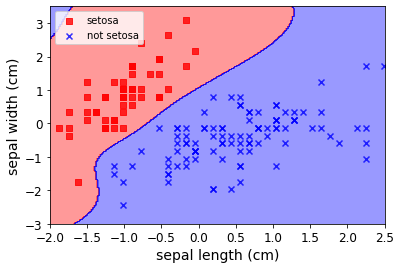

In [22]:
plot_decision_regions(X=X, y=y, classifier=rbf_svc)
plt.xlabel(feat[0])
plt.ylabel(feat[1])
plt.legend(loc='upper left')

plt.axis([-2, 2.5, -3, 3.5])
